In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import arch

lss = [(0, (1, 10)), '--', '-.', (0, (1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))]
flag_ls = True

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def sharpe(x):
    return x.mean() / x.std() * np.sqrt(12)

def sortino_ratio(x):
    mean = x.mean()
    std_neg = x[x<0].std()
    return mean / std_neg * np.sqrt(12)

def bootstrap_dataset(data, id_vars, value_var, func, n=500):
    enclosure_flag = (type(id_vars) != list) or (len(id_vars) == 1)
    if type(id_vars) != list:
        id_vars = [id_vars]
    bs_dfs = []
    for conf, group_df in data.groupby(id_vars):
        values = group_df[value_var].values
        values_size = values.size
        boot = [func(values[np.random.randint(values_size, size=values_size)]) for it in range(n)]
        if enclosure_flag: 
            conf = [conf]
        data_dict = dict(zip(id_vars, conf))
        data_dict[value_var] = boot
        
        bs_dfs.append(pd.DataFrame(data_dict))
    return pd.concat(bs_dfs)

def summary_table(expected_returns, sharpe, sortino, index_names, group_col, alpha=0.05, n_digits=2):
    alpha_2 = alpha / 2
    funcs = [
        'mean',
        lambda x: np.quantile(x, alpha_2), 
        lambda x: np.quantile(x, 1-alpha_2),
    ]
    func_names = ['mean', 'ci_low', 'ci_up']
    
    df_returns = expected_returns[expected_returns['trading_strategy'] == 'both']
    df_sharpe = sharpe[sharpe['trading_strategy'] == 'both']
    df_sortino = sortino[sortino['trading_strategy'] == 'both']
    
    agg_returns_df = df_returns.groupby(group_col)['value'].agg(funcs)
    agg_returns_df = (agg_returns_df * 100).round(n_digits).astype(str) + '\%'
    agg_returns_df.columns = func_names
    p_neg_returns = df_returns.groupby(group_col)['value'].apply(lambda x: (x < 0).mean()).round(n_digits)
    agg_sharpe_df = df_sharpe.groupby(group_col)['value'].agg(funcs).round(n_digits).astype(str)
    agg_sharpe_df.columns = func_names
    agg_sortino_df = df_sortino.groupby(group_col)['value'].agg(funcs).round(n_digits).astype(str)
    agg_sortino_df.columns = func_names
    
    summary = pd.DataFrame({
        'Excess Returns': agg_returns_df['mean'],
        'Sharpe Ratio': agg_sharpe_df['mean'],
        'Sortino Ratio': agg_sortino_df['mean'],
        # r'$\mathbb{P}(\mathbb{E}[R] < 0)$': p_neg_returns,
        '\ ': '\\\\ ',
        '\  ': ' (' + agg_returns_df['ci_low'] + '-' + agg_returns_df['ci_up'] + ')',
        '\   ': ' (' + agg_sharpe_df['ci_low'] + '-' + agg_sharpe_df['ci_up'] + ')',
        '\    ': ' (' + agg_sortino_df['ci_low'] + '-' + agg_sortino_df['ci_up'] + ')',
        # '\     ': '&'
    })
    summary.index.names = index_names
    # summary = summary.reset_index()
    
    print(summary.to_latex(bold_rows=True,
                       caption='This is the caption',
                       escape=False,
                       # column_format='lllllrlll'
                      ))
    
    return summary

# SP500

In [4]:
results_df = pd.read_pickle('data/results_CRSP.pkl')
results_df['trading_strategy'] = results_df['trading_method'].str.split(' ', expand=True).iloc[:, -1].values
results_df = results_df[results_df['avg_month_returns'] != 0].drop(columns=['index',])

clean_results_df = results_df.drop(columns=['n_positions_avg', 'n_positions_compl', 'n_positions_pair'])
melted_results_df = clean_results_df.melt(clean_results_df.columns[3:])
melted_results_df = melted_results_df[melted_results_df['value'] != 0]

melted_results_df_no_bench = melted_results_df[melted_results_df['benchmark'] == False].copy()
spreads_method_config = melted_results_df_no_bench['spreads_method'].str.split(' ', expand=True).iloc[:, 1:]
melted_results_df_no_bench['spreads_method_config'] = spreads_method_config[1] + ' ' + spreads_method_config[2]
melted_results_df_no_bench[['trading_method_name', 'w', 'q', 'gamma', 'trading_strategy']] = melted_results_df_no_bench['trading_method'].str.split(' ', expand=True)
melted_results_df_no_bench = melted_results_df_no_bench[melted_results_df_no_bench['q'] != 'q=0.5'].reset_index(drop=True)
melted_results_df_no_bench['gamma-q'] = melted_results_df_no_bench['gamma'] + ' - ' + melted_results_df_no_bench['q']
melted_results_df_no_bench['w'] = melted_results_df_no_bench['w'].str.split('=', expand=True)[1].astype(int)
melted_results_df_no_bench['corr-k'] = melted_results_df_no_bench['spreads_method'].str.split('-', expand=True)[1]
melted_results_df_no_bench['value'] = 2 ** melted_results_df_no_bench['value'] - 1

benchmark_returns = 2 ** results_df[results_df['benchmark']]['avg_month_returns'] - 1
expected_return_benchmark = benchmark_returns.mean()
expected_sharpe_benchmark = sharpe(benchmark_returns)
expected_sortino_benchmark = sortino_ratio(benchmark_returns)

sp500_index_returns = pd.read_csv('data/sp500_returns.csv', parse_dates=['Date'])
sp500_return_benchmark = sp500_index_returns['Returns'].mean()
sp500_sharpe_benchmark = sharpe(sp500_index_returns['Returns'])
sp500_sortino_benchmark = sortino_ratio(sp500_index_returns['Returns'])

## Spreads Methods

In [5]:
spread_config_filt = True

bs_expected_returns_spread_method = bootstrap_dataset(
    melted_results_df_no_bench[(spread_config_filt &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns')
                               )], 
    id_vars=['trading_strategy', 'spreads_method_name'], 
    value_var='value', func=np.mean, n=5000)

bs_expected_sharpe_spread_method = bootstrap_dataset(
    melted_results_df_no_bench[(spread_config_filt &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns')
                               )], 
    id_vars=['trading_strategy', 'spreads_method_name'], 
    value_var='value', func=sharpe, n=5000)

bs_expected_sortino_spread_method = bootstrap_dataset(
    melted_results_df_no_bench[(spread_config_filt &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns')
                               )], 
    id_vars=['trading_strategy', 'spreads_method_name'], 
    value_var='value', func=sortino_ratio, n=5000)

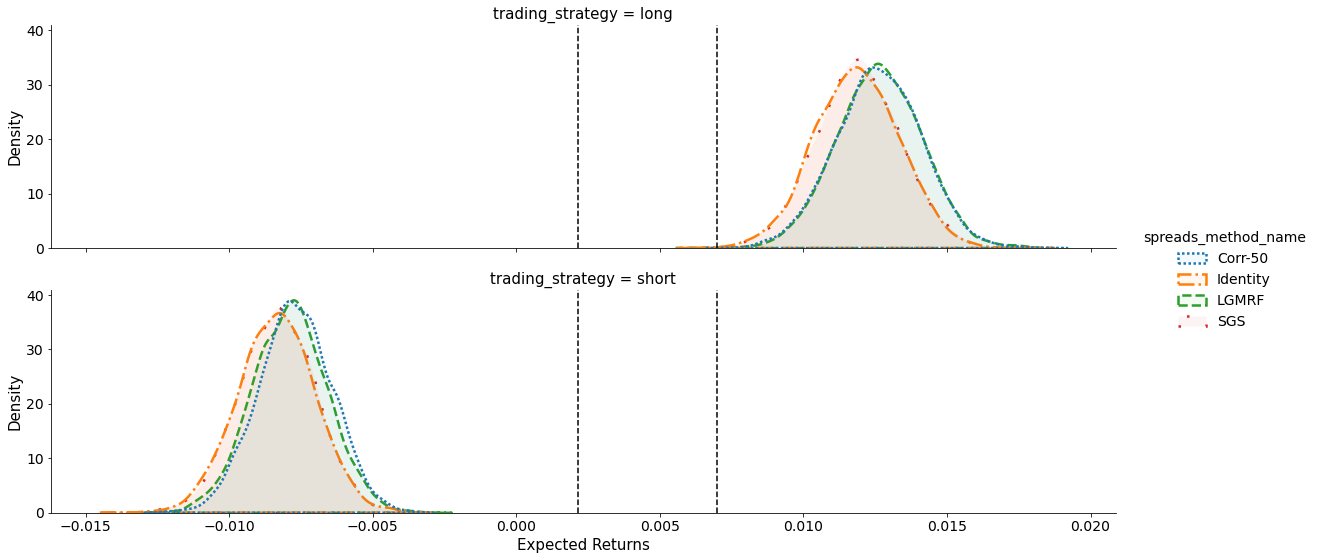

In [6]:
g = sns.displot(data=bs_expected_returns_spread_method[bs_expected_returns_spread_method['trading_strategy'] != 'both'], 
                x='value', kind='kde', fill=True, alpha=.05,
                hue='spreads_method_name', row='trading_strategy', 
                aspect=4, height=4, linewidth=2.5)
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(expected_return_benchmark, ls='--', color='black')
        ax.axvline(sp500_return_benchmark, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(expected_return_benchmark, ls='--', color='black')
        ax.axvline(sp500_return_benchmark, ls='--', color='black')


plt.xlabel('Expected Returns')
        
plt.savefig('img/CRSP_long_short_returns_spread.pdf')
plt.show()

In [7]:
summary = summary_table(bs_expected_returns_spread_method, 
                        bs_expected_sharpe_spread_method, 
                        bs_expected_sortino_spread_method, 
                        group_col='spreads_method_name', index_names=['Method'])

summary.style.highlight_max(summary.columns[:3])

\begin{table}
\centering
\caption{This is the caption}
\begin{tabular}{llllllll}
\toprule
{} & Excess Returns & Sharpe Ratio & Sortino Ratio &   \  &               \   &          \    &         \     \\
\textbf{Method  } &                &              &               &      &                   &               &               \\
\midrule
\textbf{Corr-50 } &         2.07\% &         2.42 &          5.15 &  \\  &    (1.9\%-2.23\%) &   (2.22-2.62) &   (4.15-6.33) \\
\textbf{Identity} &          2.1\% &         1.86 &          3.31 &  \\  &   (1.88\%-2.31\%) &   (1.67-2.06) &   (2.63-4.19) \\
\textbf{LGMRF   } &          2.1\% &         2.31 &          4.75 &  \\  &   (1.92\%-2.27\%) &   (2.11-2.51) &   (3.84-5.84) \\
\textbf{SGS     } &          2.1\% &         1.87 &          3.36 &  \\  &   (1.89\%-2.31\%) &   (1.67-2.07) &   (2.67-4.24) \\
\bottomrule
\end{tabular}
\end{table}



,Excess Returns,Sharpe Ratio,Sortino Ratio,\,\,\,\
Method,,,,,,,
Corr-50,2.07\%,2.42,5.15,\\,(1.9\%-2.23\%),(2.22-2.62),(4.15-6.33)
Identity,2.1\%,1.86,3.31,\\,(1.88\%-2.31\%),(1.67-2.06),(2.63-4.19)
LGMRF,2.1\%,2.31,4.75,\\,(1.92\%-2.27\%),(2.11-2.51),(3.84-5.84)
SGS,2.1\%,1.87,3.36,\\,(1.89\%-2.31\%),(1.67-2.07),(2.67-4.24)


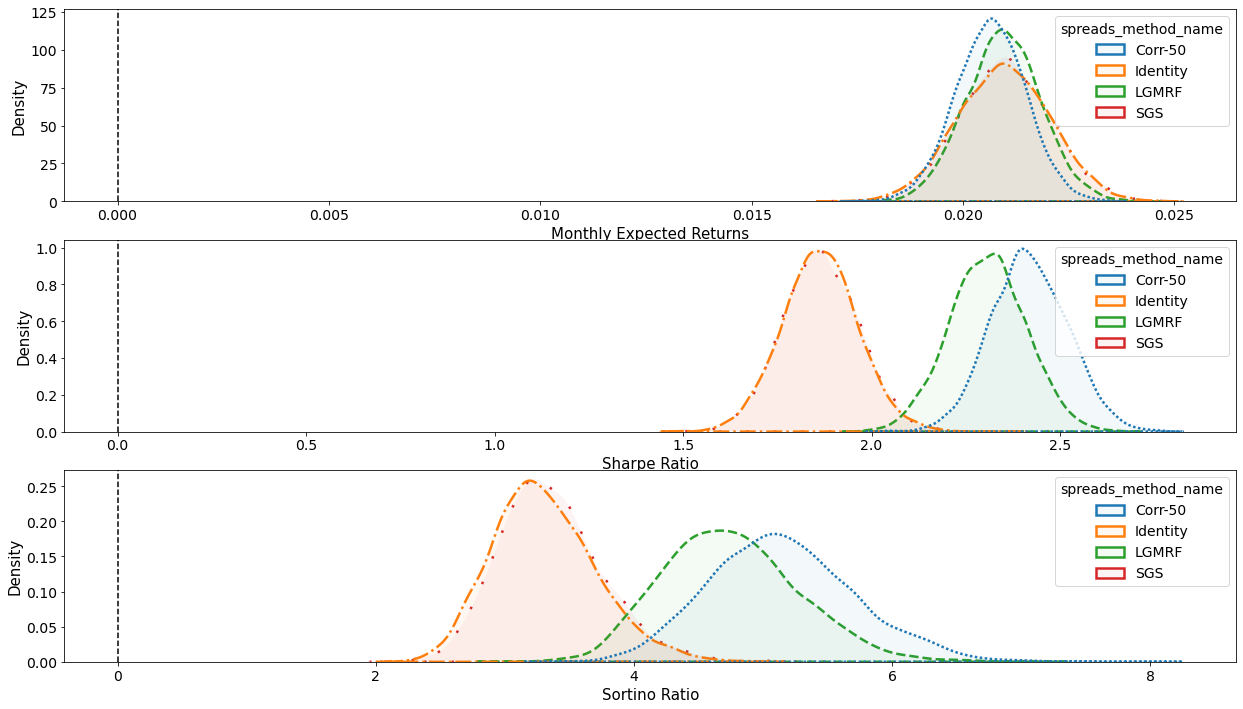

In [8]:
fig, axs = plt.subplots(3, figsize=(21, 12))

sns.kdeplot(data=bs_expected_returns_spread_method[bs_expected_returns_spread_method['trading_strategy'] == 'both'], 
            x='value', fill=True, alpha=.05, palette='tab10',
            hue='spreads_method_name', linewidth=2.5, ax=axs[0])
axs[0].set_xlabel('Monthly Expected Returns')

sns.kdeplot(data=bs_expected_sharpe_spread_method[bs_expected_sharpe_spread_method['trading_strategy'] == 'both'], 
            x='value', fill=True, alpha=.05, palette='tab10',
            hue='spreads_method_name', linewidth=2.5, ax=axs[1])
axs[1].set_xlabel('Sharpe Ratio')

sns.kdeplot(data=bs_expected_sortino_spread_method[bs_expected_sortino_spread_method['trading_strategy'] == 'both'], 
            x='value', fill=True, alpha=.05, palette='tab10',
            hue='spreads_method_name', linewidth=2.5, ax=axs[2])
axs[2].set_xlabel('Sortino Ratio')

if flag_ls:
    for ax in axs:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(0, ls='--', color='black')
else:
    for ax in axs:
        ax.axvline(0, ls='--', color='black')
        
plt.savefig('img/CRSP_spreads.pdf')
plt.show()

## Trading

In [9]:
bs_expected_returns_trading_methods = bootstrap_dataset(
    melted_results_df_no_bench[melted_results_df_no_bench['variable'] == 'avg_month_returns'], 
    id_vars=['trading_strategy', 'w', 'gamma-q'], 
    value_var='value', func=np.mean, n=5000)

bs_expected_sharpe_trading_methods = bootstrap_dataset(
    melted_results_df_no_bench[melted_results_df_no_bench['variable'] == 'avg_month_returns'], 
    id_vars=['trading_strategy', 'w', 'gamma-q'], 
    value_var='value', func=sharpe, n=5000)

bs_expected_sortino_trading_methods = bootstrap_dataset(
    melted_results_df_no_bench[melted_results_df_no_bench['variable'] == 'avg_month_returns'], 
    id_vars=['trading_strategy', 'w', 'gamma-q'], 
    value_var='value', func=sortino_ratio, n=5000)

In [10]:
aux_returns_trading_df = bs_expected_returns_trading_methods[bs_expected_returns_trading_methods['trading_strategy'] == 'both'].copy()
aux_returns_trading_df['Metric'] = 'Monthly Excess Return'
aux_sharpe_trading_df = bs_expected_sharpe_trading_methods[bs_expected_sharpe_trading_methods['trading_strategy'] == 'both'].copy()
aux_sharpe_trading_df['Metric'] = 'Sharpe Ratio'
aux_sortino_trading_df = bs_expected_sortino_trading_methods[bs_expected_sortino_trading_methods['trading_strategy'] == 'both'].copy()
aux_sortino_trading_df['Metric'] = 'Sortino Ratio'
aux_trading_df = pd.concat([aux_returns_trading_df, aux_sharpe_trading_df, aux_sortino_trading_df]).rename(columns={'gamma-q': 'Config'})
aux_trading_df

,trading_strategy,w,Config,value,Metric
0,both,1,gamma=None - q=0.2,0.017386,Monthly Excess Return
1,both,1,gamma=None - q=0.2,0.018411,Monthly Excess Return
2,both,1,gamma=None - q=0.2,0.017394,Monthly Excess Return
3,both,1,gamma=None - q=0.2,0.017928,Monthly Excess Return
4,both,1,gamma=None - q=0.2,0.018946,Monthly Excess Return
...,...,...,...,...,...
4995,both,2,gamma=2 - q=0.1,3.570346,Sortino Ratio
4996,both,2,gamma=2 - q=0.1,3.364781,Sortino Ratio
4997,both,2,gamma=2 - q=0.1,3.553799,Sortino Ratio
4998,both,2,gamma=2 - q=0.1,3.618275,Sortino Ratio


In [11]:
# aux_returns_trading_df['gamma'] = aux_returns_trading_df['gamma-q'].str.split(expand=True)[0].str.split('=', expand=True)[1]
# aux_returns_trading_df['q'] = aux_returns_trading_df['gamma-q'].str.split(expand=True)[2].str.split('=', expand=True)[1]
# aux_sharpe_trading_df['gamma'] = aux_sharpe_trading_df['gamma-q'].str.split(expand=True)[0].str.split('=', expand=True)[1]
# aux_sharpe_trading_df['q'] = aux_sharpe_trading_df['gamma-q'].str.split(expand=True)[2].str.split('=', expand=True)[1]
# aux_sortino_trading_df['gamma'] = aux_sortino_trading_df['gamma-q'].str.split(expand=True)[0].str.split('=', expand=True)[1]
# aux_sortino_trading_df['q'] = aux_sortino_trading_df['gamma-q'].str.split(expand=True)[2].str.split('=', expand=True)[1]

aux_returns_trading_df['Config'] = 'w=' + aux_returns_trading_df['w'].astype(str) + ' - ' + aux_returns_trading_df['gamma-q']
aux_sharpe_trading_df['Config'] = 'w=' + aux_sharpe_trading_df['w'].astype(str) + ' - ' + aux_sharpe_trading_df['gamma-q']
aux_sortino_trading_df['Config'] = 'w=' + aux_sortino_trading_df['w'].astype(str) + ' - ' + aux_sortino_trading_df['gamma-q']

summary = summary_table(aux_returns_trading_df, 
                        aux_sharpe_trading_df, 
                        aux_sortino_trading_df, 
                        group_col='Config', index_names=['Configuration'])

\begin{table}
\centering
\caption{This is the caption}
\begin{tabular}{llllllll}
\toprule
{} & Excess Returns & Sharpe Ratio & Sortino Ratio &   \  &               \   &          \    &         \     \\
\textbf{Configuration           } &                &              &               &      &                   &               &               \\
\midrule
\textbf{w=1 - gamma=None - q=0.2} &         1.83\% &         2.29 &          3.99 &  \\  &   (1.72\%-1.93\%) &   (2.14-2.44) &   (3.32-4.83) \\
\textbf{w=2 - gamma=2 - q=0.1   } &         2.35\% &         1.99 &          3.82 &  \\  &   (2.19\%-2.51\%) &   (1.85-2.13) &   (3.26-4.48) \\
\bottomrule
\end{tabular}
\end{table}



In [12]:
returns_idx = summary.sort_values('Excess Returns', ascending=False).iloc[:2].index
sharpe_idx = summary.sort_values('Sharpe Ratio', ascending=False).iloc[:2].index
sortino_idx = summary.sort_values('Sortino Ratio', ascending=False).iloc[:2].index

print(summary[(summary.index.isin(returns_idx) | 
               summary.index.isin(sharpe_idx) |
               summary.index.isin(sortino_idx))].to_latex(bold_rows=True,
                       caption='This is the caption',
                       escape=False,
                      ))

summary[(summary.index.isin(returns_idx) | 
               summary.index.isin(sharpe_idx) |
               summary.index.isin(sortino_idx))].style.highlight_max(summary.columns[:3])

\begin{table}
\centering
\caption{This is the caption}
\begin{tabular}{llllllll}
\toprule
{} & Excess Returns & Sharpe Ratio & Sortino Ratio &   \  &               \   &          \    &         \     \\
\textbf{Configuration           } &                &              &               &      &                   &               &               \\
\midrule
\textbf{w=1 - gamma=None - q=0.2} &         1.83\% &         2.29 &          3.99 &  \\  &   (1.72\%-1.93\%) &   (2.14-2.44) &   (3.32-4.83) \\
\textbf{w=2 - gamma=2 - q=0.1   } &         2.35\% &         1.99 &          3.82 &  \\  &   (2.19\%-2.51\%) &   (1.85-2.13) &   (3.26-4.48) \\
\bottomrule
\end{tabular}
\end{table}



,Excess Returns,Sharpe Ratio,Sortino Ratio,\,\,\,\
Configuration,,,,,,,
w=1 - gamma=None - q=0.2,1.83\%,2.29,3.99,\\,(1.72\%-1.93\%),(2.14-2.44),(3.32-4.83)
w=2 - gamma=2 - q=0.1,2.35\%,1.99,3.82,\\,(2.19\%-2.51\%),(1.85-2.13),(3.26-4.48)


In [13]:
aux_trading_df['trading_config'] = 'w=' + aux_trading_df['w'].astype(str) + ' - ' + aux_trading_df['Config']

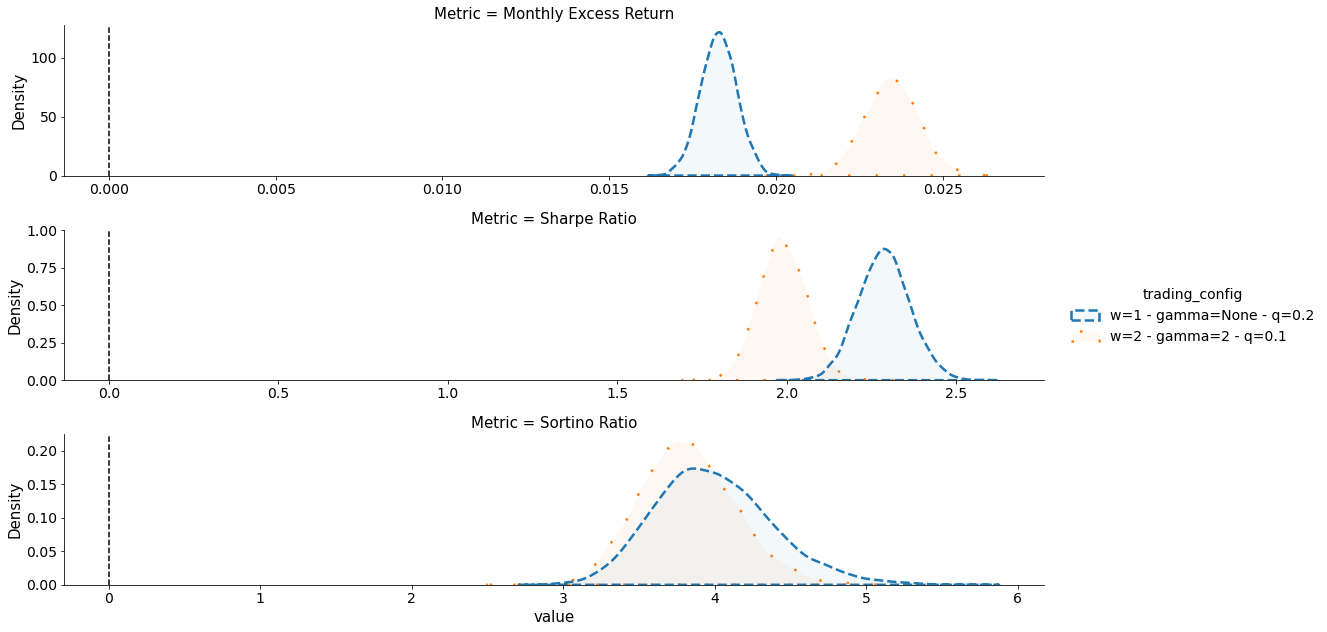

In [14]:
g = sns.displot(data=aux_trading_df, row='Metric', palette='tab10',
                x='value', kind='kde', fill=True, alpha=.05, aspect=5, height=3,
            hue='trading_config', linewidth=2.5, facet_kws=dict(sharex=False, sharey=False))
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(0, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(0, ls='--', color='black')

plt.savefig('img/CRSP_trading.pdf')
plt.show()

## Performance Over Time

In [5]:
clean_results_df = results_df.groupby(['date', 'residuals_method', 'spreads_method', 'trading_method'])['avg_month_returns'].mean().reset_index()
clean_results_df = clean_results_df[clean_results_df['trading_method'].str.endswith('both')]
clean_results_df['trading_method'] = clean_results_df['trading_method'].str[:-4]
configuration_returns = clean_results_df.pivot(index='date', columns=['residuals_method', 'spreads_method', 'trading_method'])

In [18]:
configuration_returns_year = np.log(1 + configuration_returns.copy())
configuration_returns_year['year'] = configuration_returns.index.year
# configuration_returns_year = (np.exp(configuration_returns_year.groupby('year').mean()) - 1).reset_index()
melt_configuration_returns_year = configuration_returns_year.melt('year')
# melt_configuration_returns_year['value'] = ((1 + melt_configuration_returns_year['value']) ** 12 - 1) * 100
melt_configuration_returns_year['value'] *= 12
melt_configuration_returns_year['year_2'] = (melt_configuration_returns_year['year'] // 2 * 2)
melt_configuration_returns_year

,year,NaN,residuals_method,spreads_method,trading_method,value,year_2
0,1968,avg_month_returns,residuals,Corr-50,Quantile-std w=1 q=0.2 gamma=None,0.055250,1968
1,1968,avg_month_returns,residuals,Corr-50,Quantile-std w=1 q=0.2 gamma=None,0.416175,1968
2,1968,avg_month_returns,residuals,Corr-50,Quantile-std w=1 q=0.2 gamma=None,0.279861,1968
3,1968,avg_month_returns,residuals,Corr-50,Quantile-std w=1 q=0.2 gamma=None,0.726632,1968
4,1968,avg_month_returns,residuals,Corr-50,Quantile-std w=1 q=0.2 gamma=None,-0.003658,1968
...,...,...,...,...,...,...,...
5179,2022,avg_month_returns,residuals,"SGS laplacian_root=True, adjust_laplacian=False",Quantile-std w=2 q=0.1 gamma=2,-0.163945,2022
5180,2022,avg_month_returns,residuals,"SGS laplacian_root=True, adjust_laplacian=False",Quantile-std w=2 q=0.1 gamma=2,-0.420444,2022
5181,2022,avg_month_returns,residuals,"SGS laplacian_root=True, adjust_laplacian=False",Quantile-std w=2 q=0.1 gamma=2,0.308667,2022
5182,2022,avg_month_returns,residuals,"SGS laplacian_root=True, adjust_laplacian=False",Quantile-std w=2 q=0.1 gamma=2,-0.642775,2022


In [27]:
melt_configuration_returns_year['spreads_method'] = melt_configuration_returns_year['spreads_method'].str.replace('SGS laplacian_root=True, adjust_laplacian=False', 'SGS laplacian_root=True, adjust_laplacian=True')

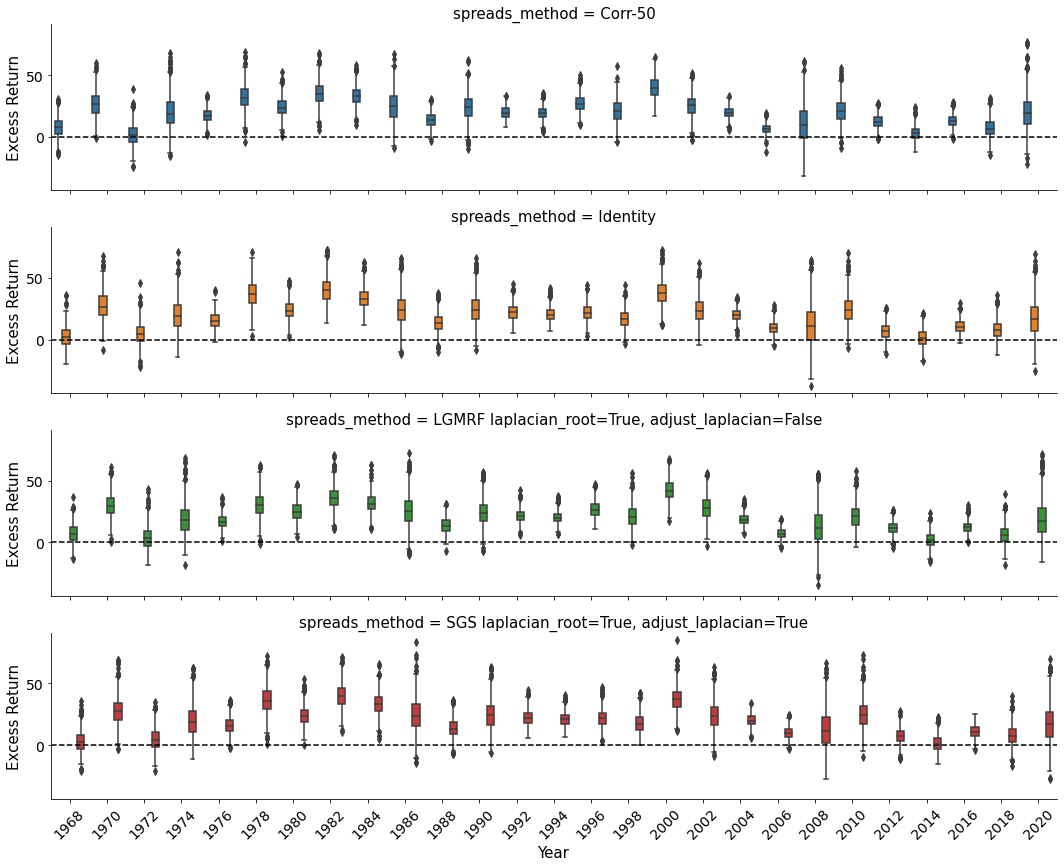

In [28]:
#configuration_returns_year
bs_expected_returns_year_spreads = bootstrap_dataset(melt_configuration_returns_year[(melt_configuration_returns_year['year'] <= 2021)], 
                                                     id_vars=['year_2', 'spreads_method'], value_var='value', func=np.mean, n=1000)
bs_expected_returns_year_spreads['value'] = (np.exp(bs_expected_returns_year_spreads['value']) - 1) * 100
g = sns.catplot(data=bs_expected_returns_year_spreads, x='year_2', y='value', 
                row='spreads_method', hue='spreads_method', height=3, aspect=5, kind="box")
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='black')
    ax.set_ylabel('Excess Return')
    
plt.xlabel('Year')
plt.xticks(rotation = 45) 
plt.savefig('img/CRSP_excess_return_overtime_spread.pdf')
plt.show()

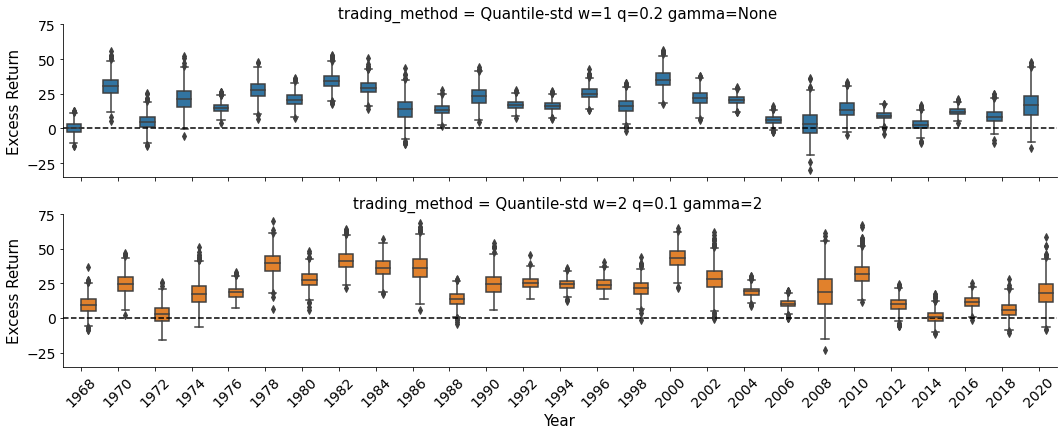

In [29]:
bs_expected_returns_year_trading = bootstrap_dataset(melt_configuration_returns_year[(melt_configuration_returns_year['year'] <= 2021)], 
                                                     id_vars=['year_2', 'trading_method'], value_var='value', func=np.mean, n=1000)
bs_expected_returns_year_trading['value'] = (np.exp(bs_expected_returns_year_trading['value']) - 1) * 100
g = sns.catplot(data=bs_expected_returns_year_trading, x='year_2', y='value', 
                row='trading_method', hue='trading_method', height=3, aspect=5, kind="box")
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='black')
    ax.set_ylabel('Excess Return')
    
plt.xlabel('Year')
plt.xticks(rotation = 45) 
plt.savefig('img/CRSP_excess_return_overtime_trading.pdf')
plt.show()

## 5-Factors

In [19]:
factors = pd.read_csv("data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=2)
factors = factors[factors['Date'].astype(str).str.strip().str.len() == 6]
factors['Date'] = pd.to_datetime(factors['Date'].str[:-2] + '-' + factors['Date'].str[-2:] + '-01')
factors = factors.set_index('Date')
factors = factors.astype(np.float64)
factors['alpha'] = 1.
factors

,Mkt-RF,SMB,HML,RMW,CMA,RF,alpha
Date,,,,,,,
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27,1.0
1963-08-01,5.07,-0.80,1.80,0.36,-0.35,0.25,1.0
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27,1.0
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,0.29,1.0
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27,1.0
...,...,...,...,...,...,...,...
2022-05-01,-0.34,-0.06,8.41,1.44,3.98,0.03,1.0
2022-06-01,-8.43,1.30,-5.97,1.85,-4.70,0.06,1.0
2022-07-01,9.57,1.88,-4.10,0.68,-6.94,0.08,1.0


In [20]:
coefs = []
pvals = []
lows = []
ups = []

for col in configuration_returns.columns:
    config_ret = configuration_returns[col] * 100
    model = sm.OLS(config_ret, factors.loc[config_ret.index])
    results = model.fit()
    
    ols_results_df = pd.DataFrame(results.summary().tables[1].data).set_index(0)
    ols_results_df.columns = ols_results_df.iloc[0]
    ols_results_df = ols_results_df.iloc[1:].astype('float')
    ols_results_coef = ols_results_df['coef']
    ols_results_pval = ols_results_df['P>|t|']
    ols_results_low = ols_results_df['[0.025']
    ols_results_up = ols_results_df['0.975]']
    
    coefs.append(ols_results_coef)
    pvals.append(ols_results_pval)
    lows.append(ols_results_low)
    ups.append(ols_results_up)
    


In [21]:
coefs_df = pd.DataFrame(coefs, index=configuration_returns[('avg_month_returns', 'residuals')].columns).round(3)
pvals_df = pd.DataFrame(pvals, index=configuration_returns[('avg_month_returns', 'residuals')].columns).round(2)
lows_df = pd.DataFrame(lows, index=configuration_returns[('avg_month_returns', 'residuals')].columns).round(2)
ups_df = pd.DataFrame(ups, index=configuration_returns[('avg_month_returns', 'residuals')].columns).round(3)

In [30]:
coefs_df.style.highlight_max()

In [22]:
coef_stat = ('$' + coefs_df.astype(str) + 
 np.vectorize(lambda x: '^{*}' * x)(((pvals_df > 0.01) & (pvals_df <= 0.05)).astype(int)) +
 np.vectorize(lambda x: '^{**}' * x)(((pvals_df > 0.001) & (pvals_df <= 0.01)).astype(int)) +
 np.vectorize(lambda x: '^{***}' * x)((pvals_df <= 0.001).astype(int)) +
 '$').reset_index()
# coef_stat['Configuration'] = coef_stat['spreads_method'].str.split(expand=True)[0] + ' ' + coef_stat['trading_method'].str[13:]

coef_stat['\ '] = '\\\\ & & & &'
coef_stat

,spreads_method,trading_method,Mkt-RF,SMB,HML,RMW,CMA,RF,alpha,\
0,Corr-50,Quantile-std w=1 q=0.2 gamma=None,$0.033$,$0.045$,$0.019$,$0.027$,$-0.046$,$0.805$,$1.103^{***}$,\\ & & & &
1,Corr-50,Quantile-std w=2 q=0.1 gamma=2,$0.048$,$0.017$,$-0.033$,$0.011$,$-0.013$,$0.628$,$1.387^{***}$,\\ & & & &
2,Identity,Quantile-std w=1 q=0.2 gamma=None,$0.012$,$0.061$,$0.06$,$0.04$,$-0.103$,$0.866$,$0.984^{***}$,\\ & & & &
3,Identity,Quantile-std w=2 q=0.1 gamma=2,$0.033$,$0.024$,$-0.013$,$0.08$,$-0.052$,$1.012$,$1.348^{***}$,\\ & & & &
4,"LGMRF laplacian_root=True, adjust_laplacian=False",Quantile-std w=1 q=0.2 gamma=None,$0.031$,$0.045$,$0.015$,$0.025$,$-0.028$,$0.853$,$1.074^{***}$,\\ & & & &
5,"LGMRF laplacian_root=True, adjust_laplacian=False",Quantile-std w=2 q=0.1 gamma=2,$0.043$,$0.014$,$-0.026$,$0.001$,$-0.016$,$0.636$,$1.433^{***}$,\\ & & & &
6,"SGS laplacian_root=True, adjust_laplacian=False",Quantile-std w=1 q=0.2 gamma=None,$0.012$,$0.061$,$0.06$,$0.04$,$-0.103$,$0.866$,$0.984^{***}$,\\ & & & &
7,"SGS laplacian_root=True, adjust_laplacian=False",Quantile-std w=2 q=0.1 gamma=2,$0.036$,$0.021$,$-0.015$,$0.077$,$-0.045$,$0.966$,$1.37^{***}$,\\ & & & &


In [23]:
configurations = coef_stat['spreads_method'].str.split(expand=True)[0] + ' ' + coef_stat['trading_method'].str[13:]
coef_stat = coef_stat.drop(columns=['spreads_method', 'trading_method'])
config_df = configurations.str.replace('w=', '').str.replace('q=', '').str.replace('gamma=', '').str.split(expand=True)
config_df.columns = ['Spread', 'w', 'q', '$\gamma$']
config_df

,Spread,w,q,$\gamma$
0,Corr-50,1,0.2,None
1,Corr-50,2,0.1,2
2,Identity,1,0.2,None
3,Identity,2,0.1,2
4,LGMRF,1,0.2,None
5,LGMRF,2,0.1,2
6,SGS,1,0.2,None
7,SGS,2,0.1,2


In [24]:
ci_df = ('(' + lows_df.astype(str) + ', ' + ups_df.astype(str) +')').reset_index(drop=True)
ci_df.columns= ['\  ', '\   ', '\    ', '\     ', '\      ', '\       ', '\        ']
ci_df

,\,\,\,\,\,\,\
0,"(-0.04, 0.111)","(-0.07, 0.159)","(-0.12, 0.162)","(-0.12, 0.179)","(-0.27, 0.182)","(-0.32, 1.927)","(0.57, 1.632)"
1,"(-0.04, 0.132)","(-0.11, 0.141)","(-0.19, 0.123)","(-0.15, 0.177)","(-0.26, 0.235)","(-0.59, 1.847)","(0.81, 1.961)"
2,"(-0.07, 0.094)","(-0.06, 0.18)","(-0.09, 0.21)","(-0.12, 0.2)","(-0.34, 0.136)","(-0.31, 2.045)","(0.43, 1.539)"
3,"(-0.06, 0.127)","(-0.11, 0.162)","(-0.19, 0.16)","(-0.1, 0.264)","(-0.33, 0.222)","(-0.34, 2.364)","(0.71, 1.985)"
4,"(-0.05, 0.109)","(-0.07, 0.161)","(-0.13, 0.16)","(-0.13, 0.178)","(-0.26, 0.203)","(-0.28, 1.987)","(0.54, 1.608)"
5,"(-0.04, 0.128)","(-0.11, 0.14)","(-0.18, 0.132)","(-0.17, 0.169)","(-0.27, 0.236)","(-0.6, 1.874)","(0.85, 2.017)"
6,"(-0.07, 0.094)","(-0.06, 0.18)","(-0.09, 0.21)","(-0.12, 0.2)","(-0.34, 0.136)","(-0.31, 2.045)","(0.43, 1.539)"
7,"(-0.06, 0.13)","(-0.12, 0.158)","(-0.19, 0.158)","(-0.11, 0.26)","(-0.32, 0.229)","(-0.38, 2.316)","(0.73, 2.006)"


In [25]:
print(pd.concat([config_df, coef_stat, ci_df], axis=1).to_latex(bold_rows=True,
                       caption='This is the caption',
                       escape=False,
                      ))

\begin{table}
\centering
\caption{This is the caption}
\begin{tabular}{llllllllllllllllllll}
\toprule
{} &    Spread &  w &    q & $\gamma$ &   Mkt-RF &      SMB &       HML &      RMW &       CMA &       RF &          alpha &          \  &             \   &            \    &           \     &          \      &         \       &        \        &      \         \\
\midrule
\textbf{0} &   Corr-50 &  1 &  0.2 &     None &  $0.033$ &  $0.045$ &   $0.019$ &  $0.027$ &  $-0.046$ &  $0.805$ &  $1.103^{***}$ &  \\ & & & & &  (-0.04, 0.111) &  (-0.07, 0.159) &  (-0.12, 0.162) &  (-0.12, 0.179) &  (-0.27, 0.182) &  (-0.32, 1.927) &  (0.57, 1.632) \\
\textbf{1} &   Corr-50 &  2 &  0.1 &        2 &  $0.048$ &  $0.017$ &  $-0.033$ &  $0.011$ &  $-0.013$ &  $0.628$ &  $1.387^{***}$ &  \\ & & & & &  (-0.04, 0.132) &  (-0.11, 0.141) &  (-0.19, 0.123) &  (-0.15, 0.177) &  (-0.26, 0.235) &  (-0.59, 1.847) &  (0.81, 1.961) \\
\textbf{2} &  Identity &  1 &  0.2 &     None &  $0.012$ &  $0.061$ &    $0.06

In [26]:
returns = sp500_index_returns.set_index('Date').loc[configuration_returns.index]
am = arch.arch_model(returns * 100, vol="Garch", p=1, o=0, q=1, dist="Normal")
forecasts = {}
for i in range(len(returns)- 60):
    res = am.fit(first_obs=i, last_obs=i + 60, disp="off")
    temp = res.forecast(horizon=1, reindex=False).variance
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast
    
garch_vol = pd.DataFrame(forecasts).T.reset_index().rename(columns={'h.1': 'Garch Vol.', 
                                                                    'index': 'Date'})
garch_vol

,Date,Garch Vol.
0,1973-06-01,10.454173
1,1973-07-01,10.819087
2,1973-08-01,11.374390
3,1973-09-01,8.650010
4,1973-10-01,21.626024
...,...,...
583,2022-01-01,21.288429
584,2022-02-01,15.025741
585,2022-03-01,47.337004
586,2022-04-01,17.105722


In [51]:
configuration_returns *= 100

In [52]:
rolling_alpha_df = pd.DataFrame({col: RollingOLS(configuration_returns[col], factors.loc[configuration_returns.index], window=60).fit().params['alpha'] for col in configuration_returns.columns},
                                index=configuration_returns.index)['avg_month_returns']['residuals'].dropna()

rolling_alpha_pval_df = pd.DataFrame({col: RollingOLS(configuration_returns[col], factors.loc[configuration_returns.index], window=60).fit().pvalues[:, -1] for col in configuration_returns.columns},
             index=configuration_returns.index)['avg_month_returns']['residuals'].dropna()

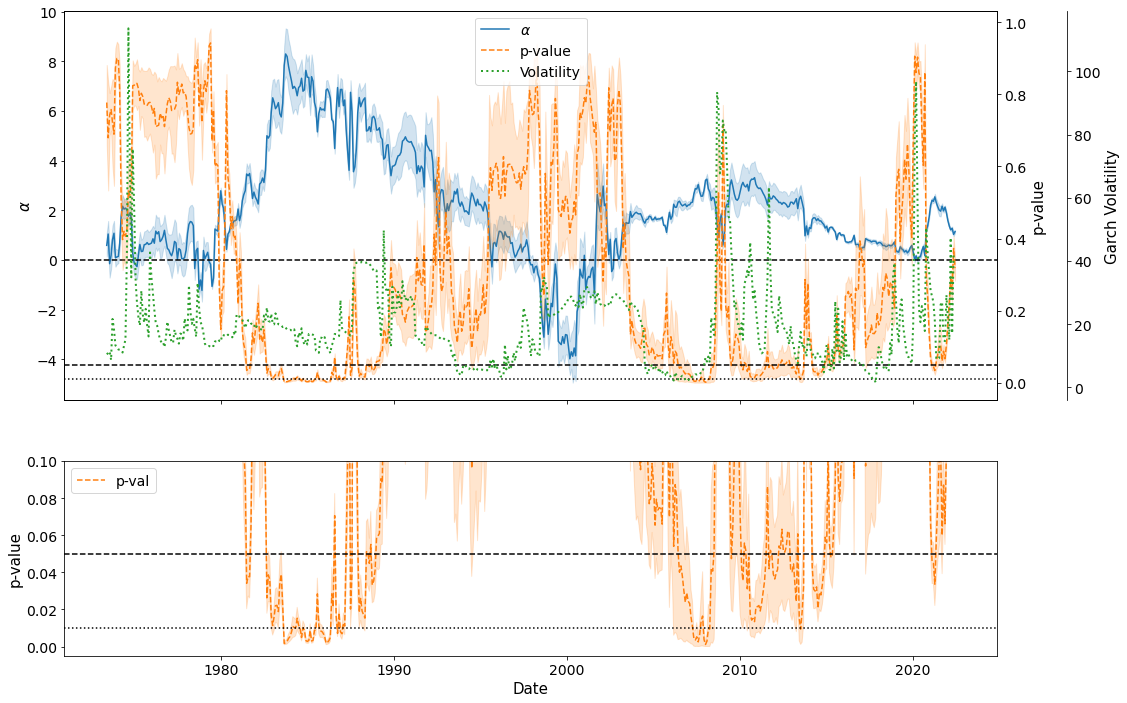

In [54]:
fig, [ax, ax_small] = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [2, 1]})

sns.lineplot(data=rolling_alpha_df.reset_index().melt('date'),
             x='date', y='value', ax=ax, label='$\\alpha$', legend=False)
ax.axhline(0, ls='--', color='black')
ax.set_ylabel('$\\alpha$')

ax2 = ax.twinx()
sns.lineplot(data=rolling_alpha_pval_df.reset_index().melt('date'),
             x='date', y='value', ax=ax2, ls='--', c='tab:orange', label='p-val', legend=False)
ax2.axhline(.05, ls='--', color='black')
ax2.axhline(.01, ls=':', color='black')
ax2.set_ylabel('p-value')

sns.lineplot(data=rolling_alpha_pval_df.reset_index().melt('date'),
             x='date', y='value', ax=ax_small, ls='--', c='tab:orange', label='p-val', legend=True)
ax_small.axhline(.05, ls='--', color='black')
ax_small.axhline(.01, ls=':', color='black')
ax_small.set_ylim(-.005, .1)
ax_small.set_ylabel('p-value')

ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 70))

sns.lineplot(data=garch_vol, lw=2,
             x='Date', y='Garch Vol.', ax=ax3, ls=':', c='tab:green', label='vol', legend=False)
ax3.set_ylabel('Garch Volatility')

fig.tight_layout()

plt.legend([ax.get_legend_handles_labels()[0][0], 
            ax2.get_legend_handles_labels()[0][0], 
            ax3.get_legend_handles_labels()[0][0],
           ], ['$\\alpha$', 'p-value', 'Volatility'])

ax.tick_params(labelbottom=False)
ax.set_xlabel('')
ax_small.set_xlabel('Date')

plt.savefig('img/CRSP_alpha_overtime.pdf')

plt.show()